In [127]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.colors as colors
import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
import glob
import h5py
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit


#import matplotlib as mpl
#mpl.use("pgf")
#pgf_with_custom_preamble = {
#    "font.family": "serif", # use serif/main font for text elements
#    "text.usetex": True,    # use inline math for ticks
#    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
#    "pgf.preamble": [
#         r"\usepackage{units}",         # load additional packages
#         r"\usepackage{metalogo}",
#         r"\usepackage{unicode-math}",  # unicode math setup
#         r"\setmathfont{xits-math.otf}",
#         r"\setmainfont{DejaVu Serif}", # serif font via preamble
#         r"\usepackage{sfmath} \boldmath",
#         ]
#}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["DejaVu Serif"]})
# for Palatino and other serif fonts use:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#})

plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['font.size'] = '20'

from importlib import reload

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_12840/1872933674.py:48: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [2]:
import athena_read

In [47]:
#This is the integral of blackbody from 0 to nu_t (h\nu/kT)
def FitBlackBody(nu_t):
    integral = 0.0;
    nu_2 = nu_t * nu_t;
    nu_3 = nu_t * nu_2;
    nu_7 = nu_2 * nu_2 * nu_3
    if nu_t < 1.8:
        integral = 0.051329911273422 * nu_3 -0.019248716727533 * nu_t * nu_3 + 0.002566495563671 * nu_2 * nu_3
        -3.055351861513195*1.e-5*nu_7
    elif nu_t < 18.6:
        exp_nu = exp(-nu_t);
        integral = -0.156915538762850 * exp_nu * (nu_3 + 2.69 * nu_2 + 6.714 * nu_t) + 1.000009331428801*(1- exp_nu);
    else:
        integral = 1.0 - 192.1*exp(-0.9014*nu_t)

    return integral;
#This is the blackbody spectrum for each frequency nu_t (h\nu/kT)
def BlackBody(nu, tr):
    nu_t=nu/tr
    exp_1=exp(nu_t)-1
    if nu_t < 1.e-5:
      exp_1=tr**3.0*nu_t**2.0
    else:
      exp_1=nu**3.0/exp_1

    spec=(15/np.pi**4.0)*exp_1

    return spec;
def BESpectrum(totn,nu, tr):
    nu_t=nu/tr
    exp_1=totn*exp(nu_t)-1
    exp_1=nu**3.0/exp_1

    spec=(15/np.pi**4.0)*exp_1

    return spec;

def BlackBodyNnu2(nu, tr):
    nu_t=nu/tr
    exp_1=exp(nu_t)-1
    if nu_t < 1.e-5:
        exp_1=tr**2.0*(nu_t-0.5*nu_t**2.0)
    else:
        exp_1=1/exp_1

    spec=exp_1

    return spec;
def ConvertJNNu2(bbj, nu_f):
    jnu4=bbj/nu_f**4
    log_jnu4=log10(jnu4)
    log_nnu2=1
    if log_jnu4 < -3.99793:
        log_nnu2 = 0.9971*log_jnu4+0.7464
    elif log_jnu4 >= -3.99793 and log_jnu4 < 2.73043:
        jsq = log_jnu4*log_jnu4
        log_nnu2 = 0.0003484*jsq*jsq+0.002327*jsq*log_jnu4-0.02137*jsq+0.8037*log_jnu4+0.3249
    else:
        log_nnu2 = 0.7506*log_jnu4+0.3773
    nnu2 = 10.0**log_nnu2*nu_f*nu_f*nu_f
    return nnu2
def ConvertJNNu2Wein(bbj, nu_f, tgas):
    nu_t=nu_f/tgas
    n_coef = 2.0+2.0*nu_t+nu_t*nu_t
    j_coef = 6.0+6.0*nu_t+3.0*nu_t*nu_t+nu_t*nu_t*nu_t
    nnu2 = bbj*np.pi**4.0*n_coef/(15.0*tgas*j_coef)
    return nnu2

In [166]:
def MakeImages(data, minval, maxval, xmin, xmax, ymin, ymax,
               xgrid,ygrid,label,xlabel,ylabel,outputname,time=None,logscale=1,
               cmap='jet'):
    plots, axes = plt.subplots(1,1,figsize=(10,3.5),dpi=300, sharex=True)
    plt.subplots_adjust(left=0.1,right=0.85,top=0.98,bottom=0.1,hspace=0.0)


#    plt.xlabel('$ x$', size = 30)
#    plt.ylabel('$ y$', size = 30)      

    if time is not None:
        plt.title(time,size=30,y=1.02)

        
    if logscale > 0:
#      im = axes.imshow(data_cart,cmap='RdGy_r', norm=LogNorm(vmin = minval, vmax=maxval), 
        im = axes.imshow(data,cmap=cmap, norm=colors.SymLogNorm(vmin = minval, vmax=maxval, linthresh=0.001, 
                                                    linscale=0.001), origin='lower', extent=[xmin,xmax,ymin,ymax])
    else:
        im = axes.imshow(data,cmap=cmap, vmin = minval, vmax=maxval,origin='lower', extent=[xmin,xmax,ymin,ymax])   

#    axes.set_yticks([-1,0,1,2,3]) 
    axes.tick_params(labelsize=20)
#    axes[0].set_ylabel('$E_r$',size=30)

    axes.set_xlabel(xlabel,size=30)
    axes.set_ylabel(ylabel,size=30)

    cbaxes = plots.add_axes([0.86,0.28,0.03,0.45])

    cbar=plots.colorbar(im,cax=cbaxes,ticks=[-1, 0.001, 0.01, 0.1, 1])
    cbar.set_label(label, size=30)
#    cbar.ax.set_yticklabels([0,100,200,300,400])
    cbar.ax.tick_params(labelsize=15)
    
    

#    axes.set_aspect('auto')
    plt.savefig(outputname)
    plt.close(plots)



In [4]:
def PlotProfile(datax, datay, xmin, xmax, ymin, ymax,  ylabel, label1, filename, xlabel='$r/r_g$', logscale=0, 
                xlogscale=0, datax1_2=None, datay1_2=None, datay1_3=None, datax2=None, datay2=None, datax2_2=None, 
                datay2_2=None, datay2_3=None, datax3=None, datay3=None, datax3_2=None, datay3_2=None, datay3_3=None, 
                datax4=None, datay4=None, datax4_2=None, datay4_2=None, datax5=None, datay5=None, label2='', 
                label3='', label4='', label5='',title=None,leg_loc=None):
    plots, axes = plt.subplots(figsize=(9,9),dpi=300)
    plt.xlabel(xlabel, size = 30)
    plt.ylabel(ylabel, size = 30)
    plt.subplots_adjust(left=0.15,right=0.88,top=0.9,bottom=0.1)
    plt.ylim([ymin,ymax])
    plt.xlim([xmin,xmax])
    if logscale > 0:
      axes.set_yscale('log')
    if xlogscale > 0:
      axes.set_xscale('log')
    if title is not None:
      plt.title(title,size=20)

    plt.plot(datax,datay,color='black',label=label1,linewidth=3.0,marker='o',mfc='none',ms=8)
    if datay1_2 is not None:
        if datax1_2 is not None:
            plt.scatter(datax1_2,datay1_2,s=80,facecolors='none', edgecolors='black')
        else:
            plt.scatter(datax1,datay1_2,s=80,facecolors='none', edgecolors='black')    
    if datay1_3 is not None:
        plt.plot(datax,datay1_3,color='black',linestyle='dashed',linewidth=4.0)
    if datay2 is not None:
        plt.plot(datax2,datay2,color='red',label=label2,linewidth=3.0,marker='o',mfc='none',ms=8)
    if datay2_2 is not None:
        if datax2_2 is not None:
            plt.scatter(datax2_2,datay2_2,s=80,facecolors='none', edgecolors='red')
        else:
            plt.scatter(datax2,datay2_2,s=80,facecolors='none', edgecolors='red')       
    if datay2_3 is not None:
        plt.plot(datax2,datay2_3,color='red',linestyle='dashed',linewidth=4.0)
    if datay3 is not None:
        plt.plot(datax3,datay3,color='green',label=label3,linewidth=3.0,linestyle='dashed')
    if datay3_2 is not None:
        if datax3_2 is not None:
            plt.scatter(datax3_2,datay3_2,s=80,facecolors='none', edgecolors='green')
        else:
            plt.scatter(datax3_2,datay3_2,s=80,facecolors='none', edgecolors='green')          
    if datay3_3 is not None:
        plt.plot(datax3,datay3_3,color='green',linestyle='dashed',linewidth=4.0)
    if datay4 is not None:
        plt.plot(datax4,datay4,color='blue',label=label4,linewidth=3.0)
        if datax4_2 is not None:
            plt.scatter(datax4_2,datay4_2,s=80,facecolors='none', edgecolors='blue')
        else:
            plt.scatter(datax4,datay4_2,s=80,facecolors='none', edgecolors='blue')
    if datay5 is not None:
      plt.plot(datax5,datay5,color=tableau20[0],label=label5,linewidth=2.0) 
    if leg_loc is not None:
      plt.legend(loc="best",bbox_to_anchor=leg_loc,frameon=False)
    axes.set_aspect('auto')
#    axes.yaxis.set_tick_params(labelsize=25)
#    axes.xaxis.set_tick_params(labelsize=25)
    plt.savefig(filename)
    plt.close(plots)



In [5]:
files=sorted(glob.glob('Data_v3.e2/thermal*athdf'))
num_file=len(files)

In [6]:
#for filename in files:
ang_file = open('Data_v3.e2/Rad_angles.txt', 'r')
Lines = ang_file.readlines()
angle_line = [ line for line in Lines if  "nu_max" in line]
angle_line=angle_line[0]

prat_line = [ line for line in Lines if  "Prat" in line]
prat_line=prat_line[0]
prat_split=prat_line.split(" ")
Prat=float(prat_split[size(prat_split)-2])


crat_line = [ line for line in Lines if  "Crat" in line]
crat_line=crat_line[0]
Crat_split=crat_line.split(" ")
Crat=float(Crat_split[size(Crat_split)-2])


angle_index=Lines.index(angle_line)+1
location=Lines.index('fre   spec\n')
tot_line=size(Lines)
nfreq=tot_line-location-1
nu_grid=np.zeros(nfreq)
histories=np.zeros((num_file,52))
for i in range(nfreq):
    line=Lines[i+location+1].split(' ')[0]
    nu_grid[i]=float(line)

nu_center=np.zeros(nfreq-1)
nu_center[:]=(nu_grid[:-1]+nu_grid[1:])/2

nu_plot=np.zeros(nfreq)
nu_plot[:-1]=nu_center
nu_plot[nfreq-1]=nu_grid[nfreq-1]

#nu_center=np.append(nu_center,nu_grid[nfreq-1])
nang=location-angle_index
mu_x=np.zeros(nang)
mu_y=np.zeros(nang)
mu_z=np.zeros(nang)
weight=np.zeros(nang)
for n in range(nang):
    line=Lines[n+angle_index].split('   ')
    mu_x[n]=float(line[1])
    mu_y[n]=float(line[2])
    mu_z[n]=float(line[3])
    weight[n]=float(line[4].rstrip())

In [213]:
tgas=np.zeros(num_file)
er_spec=np.zeros((num_file,nfreq))
specific_spec=np.zeros((num_file,nfreq-1))
data_time=np.zeros(num_file)
er_his=np.zeros(num_file)

In [214]:
for i in range(num_file):
    filename=files[i]
    with h5py.File(filename, 'r') as f:
        attributes = f.attrs.items()
        attrs = dict(attributes)
        level = f.attrs['MaxLevel']
        data_time[i] = f.attrs['Time']
        subsample = False
    data = athena_read.athdf(filename, level=level, subsample=subsample)
    if i == 0:
        vel=data['vel1']
    tgas[i]=np.mean(data['press'][0,0,:]/data['rho'][0,0,:])
    er_his[i]=0.0
    for j in range(nfreq):
        varname='Er_'+str(j)
        er_spec[i,j]=np.mean(data[varname][0,0,:])
        er_his[i] = er_his[i] + er_spec[i,j]
    for j in range(nfreq-1):
        specific_spec[i,j]= er_spec[i,j]/(nu_grid[j+1]-nu_grid[j])

In [211]:
print(tgas)
print(er_his)
print(er_his[1]**0.25)
print(Prat*er_his[0]+tgas[0]/(5/3-1))
print(Prat*er_his[num_file-1]+tgas[num_file-1]/(5/3-1))

ntot_0=0
for i in range(nfreq-1):
    ntot_0=ntot_0+er_spec[0,i]*(np.pi**4/15.0)/nu_center[i]
nnu2_last0=ConvertJNNu2Wein(er_spec[0,nfreq-1], nu_grid[nfreq-1], tgas[0])
ntot_0=ntot_0+nnu2_last0
print(ntot_0)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1.          1.99938999  3.74732466  6.3383606   9.55680046 12.99735395
 16.27805059 19.15625602 21.52929112 23.39634379 24.81046278 25.84767804
 26.58526922 27.09310148 27.42891516 27.6386539  27.75731098 27.81107434
 27.81905828 27.79505164 27.74888194 27.68745524 27.61563291 27.53675748
 27.4531807  27.36647579 27.27776594 27.18777356 27.09703756 27.00587535
 26.91455038 26.823194

TypeError: 'module' object is not callable

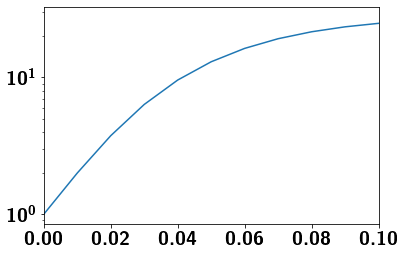

In [218]:
plt.plot(data_time,er_his)
plt.xlim(0,0.1)
plt.yscale('log')

In [207]:
sigma_s=data['Sigma_s_0'][0,0,0]
telec=5.94065e9/1.e5
yfinal=Crat*sigma_s*time[num_file-1]/telec
print(yfinal)
vsq=300**2/2
v_eff_T=1+telec*vsq/(3*Crat*Crat)
v_eff_T2=1+2*telec*vsq/(3*Crat*Crat)
print(v_eff_T,v_eff_T2)
print((2*telec*vsq/(Crat*Crat))**0.5)

2.7572740356694974
14.284873449708615 27.56974689941723
8.928003175304749


(1e-10, 1)

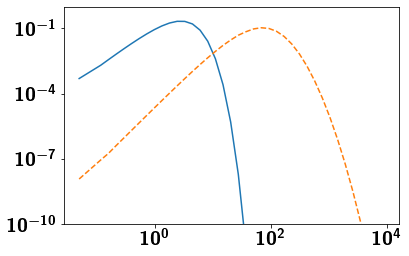

In [11]:
plt.plot(nu_center,specific_spec[0,:])
plt.plot(nu_center,specific_spec[num_file-1,:],linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-10,1)

In [ ]:
Solve[N[Integrate[
    15/\[Pi]^4*(x^3*vtr^4)/(amp*Exp[x] - 1), {x, 0, \[Infinity]}]] == 
  15.036, amp]

68.21997
[1.18495458e-08 8.90255201e-08 1.77287646e-07 4.02658136e-07
 8.94800135e-07 1.99353756e-06 4.43232147e-06 9.83497512e-06
 2.17577496e-05 4.79492945e-05 1.05081017e-04 2.28675287e-04
 4.92464926e-04 1.04728347e-03 2.18368017e-03 4.45313655e-03
 8.74865530e-03 1.65506251e-02 2.91828079e-02 4.84588473e-02
 7.01787389e-02 9.44961772e-02 1.07010458e-01 9.93832739e-02
 7.34126330e-02 4.24296389e-02 1.90621512e-02 6.65146716e-03
 1.80431518e-03 3.80607024e-04 6.23253396e-05 7.88700667e-06
 7.65233053e-07 5.62660372e-08 3.08586731e-09 1.23768063e-10
 3.61619704e-12 1.35798683e-13 3.83624918e-14]
24.17913193263015


(1e-10, 1)

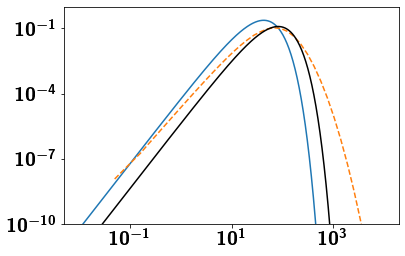

In [204]:
peak_index=specific_spec[num_file-1,:].argmax()
print(nu_center[peak_index])
fitarray=np.arange(-2,4,0.01)
fitarray=10**fitarray
size=len(fitarray)
fitbd=np.zeros(size)
fitbe=np.zeros(size)
fitbe2=np.zeros(size)
tr=nu_center[peak_index]/2.82144
norm=tr**4/er_his[num_file-1]
norm2=v_eff_T**4/er_his[num_file-1]
for i in range(size):
    fitbd[i]=BlackBody(fitarray[i],tr)/norm
    fitbe[i]=BESpectrum(2558.84,fitarray[i],v_eff_T)
    fitbe2[i]=BESpectrum(35502.5,fitarray[i],v_eff_T2)
print(specific_spec[num_file-1,:])
print(tr)
plt.plot(fitarray,fitbe)
plt.plot(nu_center,specific_spec[num_file-1,:],linestyle='dashed')
plt.plot(fitarray,fitbe2,color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-10,1)

In [205]:
ylabel='$E_r(\\tilde{\\nu})$'
filename='bulk_compton_spectrum.pdf'
xlabel="$\\tilde{\\nu}$"
label2='$y=2.76$'

#print(histories[:,0])
PlotProfile(nu_center,specific_spec[0,:],1.e-2, 1.e4, 1.e-8, 1, ylabel, '$y=0$',filename, xlabel,logscale=1,
            xlogscale=1,
            datax2=nu_center,datay2=specific_spec[num_file-1,:], 
            datax3=fitarray,datay3=fitbe2,label2=label2,leg_loc=(0.66,0.85))

In [14]:
## fit the power law slope at low and high frequency end
## fit low frequency end
low_fre=np.fabs(nu_center-20).argmin()
z = np.polyfit(np.log10(nu_center[:low_fre]), np.log10(specific_spec[num_file-1,:low_fre]), 1)
print(z)
high_fre=np.fabs(nu_center-600).argmin()
highz = np.polyfit(np.log10(nu_center[high_fre:]), np.log10(specific_spec[num_file-1,high_fre:]), 1)
print(highz)

[ 2.53707862 -4.66628078]
[-8.97855892 21.82817335]


In [154]:
#check spatial distribution
filename=files[num_file-1]
with h5py.File(filename, 'r') as f:
    attributes = f.attrs.items()
    attrs = dict(attributes)
    level = f.attrs['MaxLevel']
    subsample = False
    data = athena_read.athdf(filename, level=level, subsample=subsample)
    xpos=data['x1v']
    nx1=len(data['x1v'])
    er_spatial_spec=np.zeros((nx1,nfreq-1))
    for i in range(nx1):
        for j in range(nfreq-1):
            varname='Er_'+str(j)
            er_spatial_spec[i,j]=data[varname][0,0,i]/(nu_grid[j+1]-nu_grid[j])
#subtract the mean and divide the mean to show the fluctuation
for j in range(nfreq-1):
    er_spatial_spec[:,j] = (er_spatial_spec[:,j] - np.mean(er_spatial_spec[:,j]))/np.mean(er_spatial_spec[:,j])


In [169]:
np.fabs(-10)
print(np.log10(nu_center[3]))

-0.6660884499586752


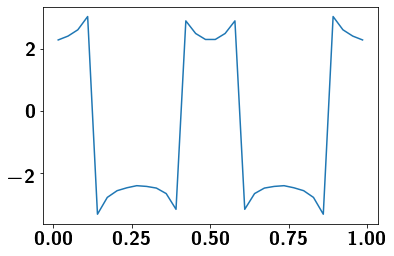

In [152]:
plt.plot(xpos,er_spatial_spec[:,2])

In [171]:
label='$\\delta E_{r}(x,\\tilde{\\nu})$'
outputname='bulk_compton_spatial.pdf'
xlabel='$\\log_{10}(\\tilde{\\nu})$'
ylabel='$x$'
MakeImages(er_spatial_spec[:,3:], -5, 5, -0.67, 3, 0, 1, nu_center[3:], xpos,
              label,xlabel,ylabel,outputname,logscale=1,cmap='inferno')

In [15]:
files2=sorted(glob.glob('Data_NoCompton/thermal*athdf'))
num_file2=len(files2)

In [16]:
er_spec2=np.zeros((num_file2,nfreq))
er_spec2=np.zeros((num_file,nfreq))
er_his2=np.zeros(num_file2)
specific_spec2=np.zeros((num_file2,nfreq-1))

In [17]:
for i in range(num_file2):
    filename=files2[i]
    with h5py.File(filename, 'r') as f:
        attributes = f.attrs.items()
        attrs = dict(attributes)
        level = f.attrs['MaxLevel']
        time[i] = f.attrs['Time']
        subsample = False
    data = athena_read.athdf(filename, level=level, subsample=subsample)
    er_his2[i]=0.0
    for j in range(nfreq):
        varname='Er_'+str(j)
        er_spec2[i,j]=np.mean(data[varname][0,0,:])
        er_his2[i] = er_his2[i] + er_spec2[i,j]
    for j in range(nfreq-1):
        specific_spec2[i,j]= er_spec2[i,j]/(nu_grid[j+1]-nu_grid[j])

(1e-10, 1)

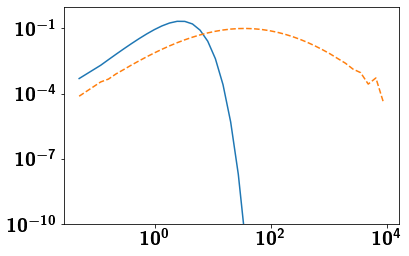

In [19]:
plt.plot(nu_center,specific_spec[0,:])
plt.plot(nu_center,specific_spec2[5,:],linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-10,1)

In [257]:
files3=sorted(glob.glob('Data_shear/thermal*athdf'))
num_file3=len(files3)

In [258]:
er_spec3=np.zeros((num_file3,nfreq))
er_his3=np.zeros(num_file3)
specific_spec3=np.zeros((num_file3,nfreq-1))
prxy_spec3=np.zeros((num_file3,nfreq))
data_time3=np.zeros(num_file3)

In [259]:
for i in range(num_file3):
    filename=files3[i]
    with h5py.File(filename, 'r') as f:
        attributes = f.attrs.items()
        attrs = dict(attributes)
        level = f.attrs['MaxLevel']
        data_time3[i] = f.attrs['Time']
        subsample = False
    data = athena_read.athdf(filename, level=level, subsample=subsample)
    er_his3[i]=0.0
    for j in range(nfreq):
        varname='Er_'+str(j)
        er_spec3[i,j]=np.mean(data[varname][0,0,:])
        er_his3[i] = er_his3[i] + er_spec3[i,j]
        varname='Pr_'+str(j)+'_12'
        prxy_spec3[i,j]=np.mean(data[varname][0,0,:])/er_spec3[i,j]
    for j in range(nfreq-1):
        specific_spec3[i,j]= er_spec3[i,j]/(nu_grid[j+1]-nu_grid[j])

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_12840/2969488287.py:16: RuntimeWarning: invalid value encountered in true_divide
  prxy_spec3[i,j]=np.mean(data[varname][0,0,:])/er_spec3[i,j]


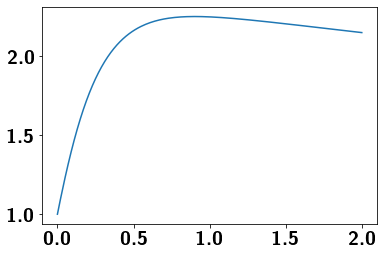

In [260]:
plt.plot(data_time3,er_his3)

(1e-10, 1)

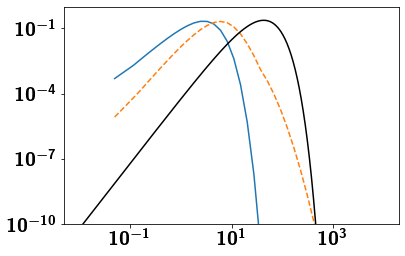

In [261]:
plt.plot(nu_center,specific_spec3[0,:])
plt.plot(nu_center,specific_spec3[num_file3-1,:],linestyle='dashed')
plt.plot(fitarray,fitbe,color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-10,1)

In [37]:
peak_index=specific_spec3[num_file3-1,:].argmax()
size=len(fitarray)
fitbd3=np.zeros(size)
tr=nu_center[peak_index]/2.82144
norm=tr**4/er_his3[num_file3-1]
for i in range(size):
    fitbd3[i]=BlackBody(fitarray[i],tr)/norm

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_12840/104872166.py:20: RuntimeWarning: overflow encountered in exp
  exp_1=exp(nu_t)-1


In [262]:
low_fre=np.fabs(nu_center-5).argmin()
z = np.polyfit(np.log10(nu_center[:low_fre]), np.log10(specific_spec3[num_file3-1,:low_fre]), 1)
print(z)
high_fre=np.fabs(nu_center-50).argmin()
highz = np.polyfit(np.log10(nu_center[high_fre:]), np.log10(specific_spec3[num_file3-1,high_fre:]), 1)
print(highz)

[ 2.37572924 -1.92607013]
[-10.10542303  15.50224503]


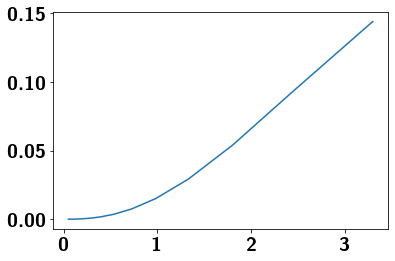

In [229]:
plt.plot(nu_center[:low_fre],specific_spec3[num_file3-1,:low_fre])

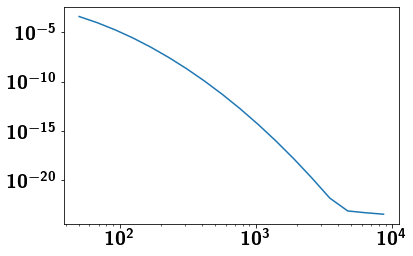

In [232]:
plt.plot(nu_center[high_fre:],specific_spec3[num_file3-1,high_fre:])
plt.xscale('log')
plt.yscale('log')

In [234]:
filename=files[num_file3-1]
with h5py.File(filename, 'r') as f:
    attributes = f.attrs.items()
    attrs = dict(attributes)
    level = f.attrs['MaxLevel']
    subsample = False
    data3 = athena_read.athdf(filename, level=level, subsample=subsample)
    xpos=data3['x1v']
    nx1=len(data3['x1v'])
    er_spatial_spec3=np.zeros((nx1,nfreq-1))
    for i in range(nx1):
        for j in range(nfreq-1):
            varname='Er_'+str(j)
            er_spatial_spec3[i,j]=data3[varname][0,0,i]/(nu_grid[j+1]-nu_grid[j])
#subtract the mean and divide the mean to show the fluctuation
for j in range(nfreq-1):
    er_spatial_spec3[:,j] = (er_spatial_spec3[:,j] - np.mean(er_spatial_spec3[:,j]))/np.mean(er_spatial_spec3[:,j])


In [235]:
label='$\\delta E_{r}(x,\\tilde{\\nu})$'
outputname='shear_compton_spatial.pdf'
xlabel='$\\log_{10}(\\tilde{\\nu})$'
ylabel='$x$'
MakeImages(er_spatial_spec3[:,3:], -5, 5, -0.67, 3, 0, 1, nu_center[3:], xpos,
              label,xlabel,ylabel,outputname,logscale=1,cmap='inferno')

In [263]:
tauk=10/(2*np.pi);
Qtauk=tauk-(3.0/4)*tauk**3*(2/3+tauk**2-tauk*(1+tauk**2)*np.arctan(1/tauk))
fk=(2/tauk)*(1/Qtauk-1/tauk)
reduc=tauk**2*fk
print(fk,reduc)

0.0743461292922363 0.18832094547789158


In [265]:
print(er_his3[num_file3-1])

2.148324541290565


In [264]:
v_eff_T3=1+fk*telec*vsq/(3*Crat*Crat)
print(v_eff_T3)

1.987678919123034


/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_12840/810611646.py:31: RuntimeWarning: overflow encountered in exp
  exp_1=totn*exp(nu_t)-1


(1e-10, 1)

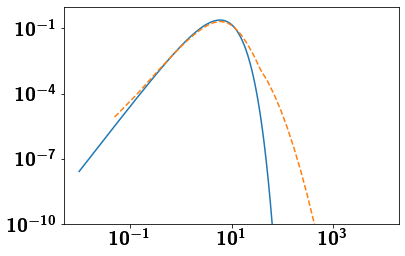

In [266]:
fitbe3=np.zeros(size)
for i in range(size):
    fitbe3[i]=BESpectrum(6.77801,fitarray[i],v_eff_T3)
plt.plot(fitarray,fitbe3)
plt.plot(nu_center,specific_spec3[num_file3-1,:],linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-10,1)

In [268]:
ylabel='$E_r(\\tilde{\\nu})$'
filename='bulk_shear_spectrum.pdf'
xlabel="$\\tilde{\\nu}$"
label2='$y=2.76$'

#print(histories[:,0])
PlotProfile(nu_center,specific_spec3[0,:],1.e-2, 1.e3, 1.e-8, 1, ylabel, '$y=0$',filename, xlabel,logscale=1,
            xlogscale=1,
            datax2=nu_center,datay2=specific_spec3[num_file3-1,:], label2=label2,
            datax3=fitarray,datay3=fitbe3,leg_loc=(0.66,0.98))

In [256]:
num_file3

102